In [1]:
# Step 1: Import necessary libraries and modules
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Step 2: Define image size
IMAGE_SIZE = [224, 224]

In [4]:
# Step 3: Define paths for training, testing, and validation data
train_path = r'/kaggle/input/hair-newdata/dataset/train'
test_path = r'/kaggle/input/hair-newdata/dataset/test'
val_path = r'/kaggle/input/hair-newdata/dataset/val'

In [5]:
# Step 4: Load the pre-trained VGG19 model with specific input shape and exclude top classification layers
rn = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


80134624/80134624 [==============================] - 0s 0us/step


In [6]:
# Step 5: Define a function to get available GPUs
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

get_available_gpus()

['/device:CPU:0', '/device:GPU:0']

In [7]:
# Step 6: Freeze layers in the VGG19 model
for layer in rn.layers:
    layer.trainable = False

In [8]:
# Step 7: Get folders (classes) in the training data directory
folders = glob(train_path+'\*')

In [9]:
# Step 8: Flatten the VGG19 model's output
x = Flatten()(rn.output)

In [10]:

# Step 9: Add a dense layer with softmax activation for classification
prediction = Dense(10, activation='softmax')(x)
model = Model(inputs=rn.input, outputs=prediction)

In [11]:
# Step 10: Display model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
# Step 11: Create data generators for training, testing, and validation with image rescaling
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
# Step 12: Create data generators for training, testing, and validation sets
training_set = train_datagen.flow_from_directory(directory=train_path,
                target_size = (224,224),
                batch_size = 64,
                class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(directory=test_path,
                target_size = (224,224),
                batch_size = 64,
                class_mode = 'categorical', shuffle=False)
val_set = val_datagen.flow_from_directory(directory=val_path,
                target_size = (224,224),
                batch_size = 64,
                class_mode = 'categorical', shuffle=False)


Found 9600 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.


In [14]:

# Step 13: Define optimizer and compile the model with loss and metrics
import keras
import tensorflow as tf
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=["acc"]
)

In [15]:
# Step 14: Import callbacks and create callbacks for learning rate reduction and model checkpointing
import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

annealer = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('/temp/{epoch}_VGG19.h5', verbose=1, save_best_only=False, mode='auto', save_freq='epoch')


In [16]:
# Step 15: Train the model
history = model.fit(
                  training_set,
                  validation_data=val_set,
                  epochs=20,
                  batch_size=128,
                  callbacks=[annealer, checkpoint],
                  steps_per_epoch=len(training_set),
                  validation_steps=len(test_set)
                )

Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 0.6851 - acc: 0.8011
Epoch 1: saving model to /temp/1_VGG19.h5
150/150 [==============================] - 87s 509ms/step - loss: 0.6851 - acc: 0.8011 - val_loss: 0.2249 - val_acc: 0.9567 - lr: 0.0010
Epoch 2/20
150/150 [==============================] - ETA: 0s - loss: 0.1092 - acc: 0.9826
Epoch 2: saving model to /temp/2_VGG19.h5
150/150 [==============================] - 54s 357ms/step - loss: 0.1092 - acc: 0.9826 - val_loss: 0.1313 - val_acc: 0.9733 - lr: 0.0010
Epoch 3/20
150/150 [==============================] - ETA: 0s - loss: 0.0500 - acc: 0.9941
Epoch 3: saving model to /temp/3_VGG19.h5
150/150 [==============================] - 49s 323ms/step - loss: 0.0500 - acc: 0.9941 - val_loss: 0.1015 - val_acc: 0.9742 - lr: 0.0010
Epoch 4/20
150/150 [==============================] - ETA: 0s - loss: 0.0268 - acc: 0.9990
Epoch 4: saving model to /temp/4_VGG19.h5
150/150 [==============================] - 49s 328ms/step

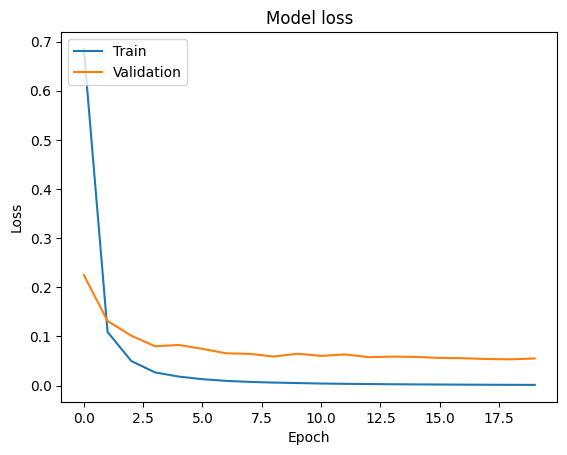

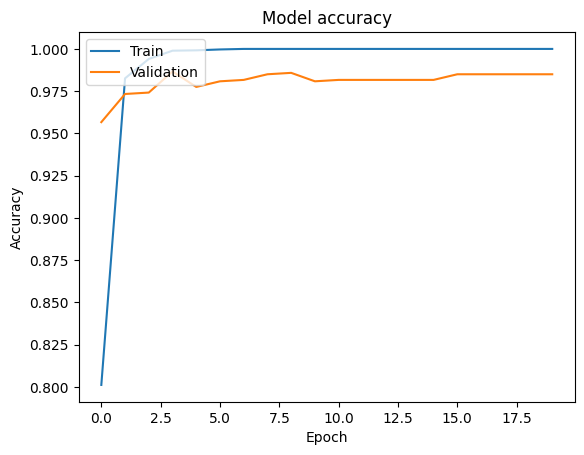

In [17]:
# Visualize loss and accuracy
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


19/19 [==============================] - 6s 294ms/step


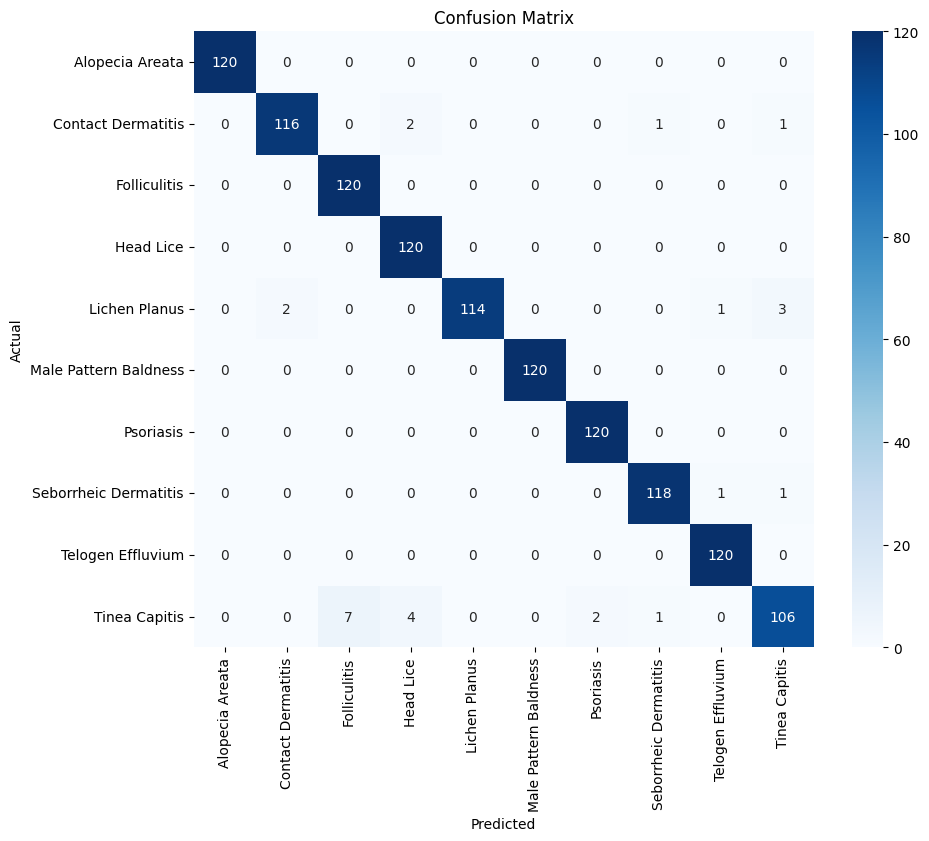

                       precision    recall  f1-score   support

      Alopecia Areata       1.00      1.00      1.00       120
   Contact Dermatitis       0.98      0.97      0.97       120
         Folliculitis       0.94      1.00      0.97       120
            Head Lice       0.95      1.00      0.98       120
        Lichen Planus       1.00      0.95      0.97       120
Male Pattern Baldness       1.00      1.00      1.00       120
            Psoriasis       0.98      1.00      0.99       120
Seborrheic Dermatitis       0.98      0.98      0.98       120
    Telogen Effluvium       0.98      1.00      0.99       120
        Tinea Capitis       0.95      0.88      0.92       120

             accuracy                           0.98      1200
            macro avg       0.98      0.98      0.98      1200
         weighted avg       0.98      0.98      0.98      1200



In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on the test set
y_pred = model.predict(test_set)
y_true = test_set.classes

# Get the class labels
class_labels = list(test_set.class_indices.keys())

# Create a confusion matrix
conf_matrix = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=class_labels))


In [20]:
# Save the model
model.save('vgg16_experiment.h5')

# InceptionV3

In [21]:
# Step 1: Import necessary libraries and modules
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf

# Step 2: Define image size
IMAGE_SIZE = [299, 299]  # InceptionV3 requires (299, 299) input size

# Step 3: Define paths for training, testing, and validation data
train_path = r'/kaggle/input/hair-newdata/dataset/train'
test_path = r'/kaggle/input/hair-newdata/dataset/test'
val_path = r'/kaggle/input/hair-newdata/dataset/val'

# Step 4: Load the pre-trained InceptionV3 model with specific input shape and exclude top classification layers
rn = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Step 5: Define a function to get available GPUs
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

get_available_gpus()

# Step 6: Freeze layers in the InceptionV3 model
for layer in rn.layers:
    layer.trainable = False
    
# Step 7: Get folders (classes) in the training data directory
folders = glob(train_path + '/*')

# Step 8: Flatten the InceptionV3 model's output
x = Flatten()(rn.output)

# Step 9: Add a dense layer with softmax activation for classification
prediction = Dense(len(folders), activation='softmax')(x)  # Assumes one folder per class
model = Model(inputs=rn.input, outputs=prediction)

# Step 10: Display model summary
model.summary()

# Step 11: Create data generators for training, testing, and validation with image rescaling
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Step 12: Create data generators for training, testing, and validation sets
training_set = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=IMAGE_SIZE,
    batch_size=64,
    class_mode='categorical'
)
test_set = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=IMAGE_SIZE,
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)
val_set = val_datagen.flow_from_directory(
    directory=val_path,
    target_size=IMAGE_SIZE,
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Step 13: Define optimizer and compile the model with loss and metrics
import keras
import tensorflow as tf
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=["acc"]
)

# Step 14: Import callbacks and create callbacks for learning rate reduction and model checkpointing
import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

annealer = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('/kaggle/working/{epoch}_InceptionV3.h5', verbose=1, save_best_only=False, mode='auto', save_freq='epoch')

# Step 15: Train the model
history = model.fit(
    training_set,
    validation_data=val_set,
    epochs=20,
    batch_size=128,
    callbacks=[annealer, checkpoint],
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)


87910968/87910968 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                

19/19 [==============================] - 9s 398ms/step


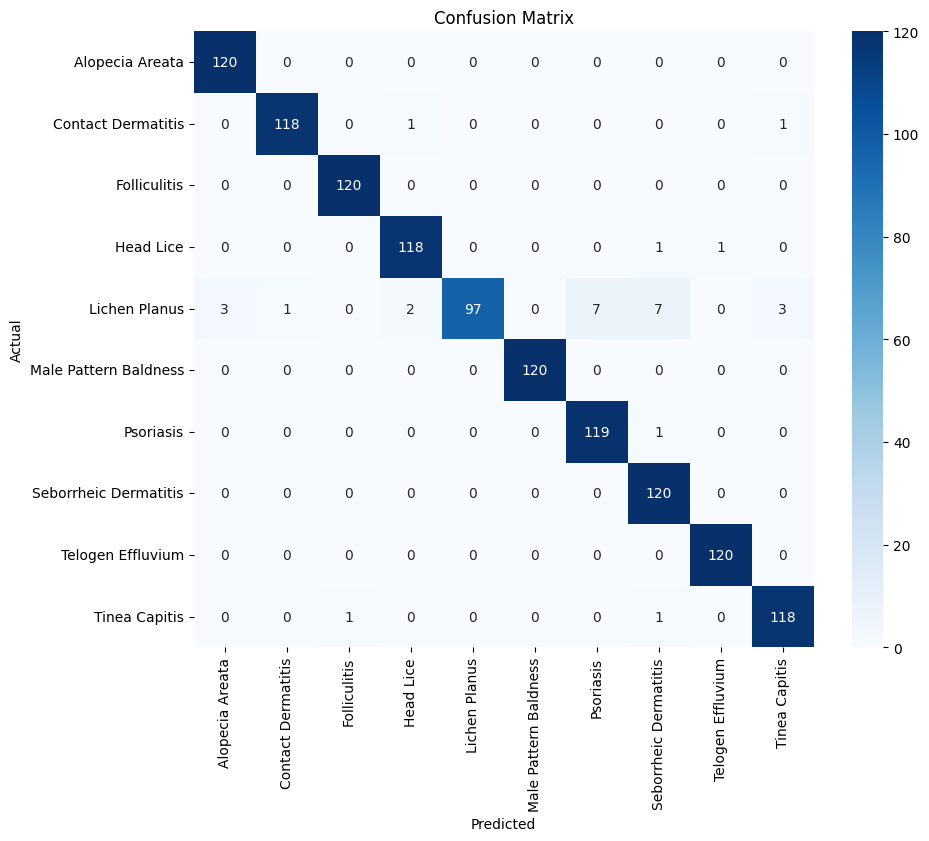

                       precision    recall  f1-score   support

      Alopecia Areata       0.98      1.00      0.99       120
   Contact Dermatitis       0.99      0.98      0.99       120
         Folliculitis       0.99      1.00      1.00       120
            Head Lice       0.98      0.98      0.98       120
        Lichen Planus       1.00      0.81      0.89       120
Male Pattern Baldness       1.00      1.00      1.00       120
            Psoriasis       0.94      0.99      0.97       120
Seborrheic Dermatitis       0.92      1.00      0.96       120
    Telogen Effluvium       0.99      1.00      1.00       120
        Tinea Capitis       0.97      0.98      0.98       120

             accuracy                           0.97      1200
            macro avg       0.98      0.97      0.97      1200
         weighted avg       0.98      0.97      0.97      1200



In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on the test set
y_pred = model.predict(test_set)
y_true = test_set.classes

# Get the class labels
class_labels = list(test_set.class_indices.keys())

# Create a confusion matrix
conf_matrix = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=class_labels))


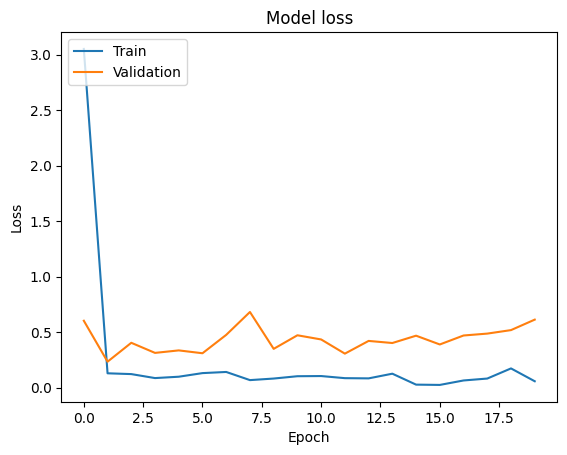

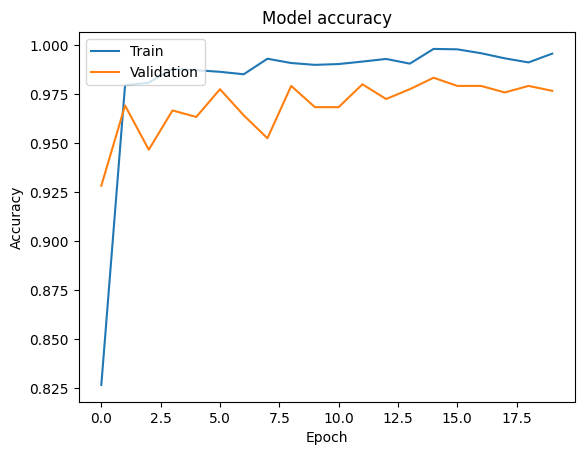

In [23]:
# Visualize loss and accuracy
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## VGG19 With Output Lables

In [24]:
# Step 1: Import necessary libraries and modules
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import os  # Import the 'os' library for directory operations

# Step 2: Define image size
IMAGE_SIZE = [299, 299]  # InceptionV3 requires (299, 299) input size

# Step 3: Define paths for training, testing, and validation data
train_path = r'/kaggle/input/hair-newdata/dataset/train'
test_path = r'/kaggle/input/hair-newdata/dataset/test'
val_path = r'/kaggle/input/hair-newdata/dataset/val'

# Step 4: Load the pre-trained InceptionV3 model with specific input shape and exclude top classification layers
rn = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Step 5: Define a function to get available GPUs
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

get_available_gpus()

# Step 6: Freeze layers in the InceptionV3 model
for layer in rn.layers:
    layer.trainable = False

# Step 7: Define a function to fetch class names from the directory structure
def get_class_names(data_dir):
    class_names = os.listdir(data_dir)
    return class_names

# Step 8: Fetch class names from the training data directory
train_class_names = get_class_names(train_path)

# Step 9: Flatten the InceptionV3 model's output
x = Flatten()(rn.output)

# Step 10: Add a dense layer with softmax activation for classification
prediction = Dense(len(train_class_names), activation='softmax')(x)  # Assumes one folder per class
model = Model(inputs=rn.input, outputs=prediction)

# Step 11: Display model summary
model.summary()

# Step 12: Create data generators for training, testing, and validation with image rescaling
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Step 13: Create data generators for training, testing, and validation sets
training_set = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=IMAGE_SIZE,
    batch_size=64,
    class_mode='categorical'
)
test_set = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=IMAGE_SIZE,
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)
val_set = val_datagen.flow_from_directory(
    directory=val_path,
    target_size=IMAGE_SIZE,
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Step 14: Define optimizer and compile the model with loss and metrics
import keras
import tensorflow as tf
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=["acc"]
)

# Step 15: Import callbacks and create callbacks for learning rate reduction and model checkpointing
import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

annealer = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('/kaggle/working/{epoch}_InceptionV3.h5', verbose=1, save_best_only=False, mode='auto', save_freq='epoch')

# Step 16: Train the model
history = model.fit(
    training_set,
    validation_data=val_set,
    epochs=2,
    batch_size=128,
    callbacks=[annealer, checkpoint],
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [26]:
train_class_names

['Telogen Effluvium',
 'Male Pattern Baldness',
 'Tinea Capitis',
 'Contact Dermatitis',
 'Lichen Planus',
 'Alopecia Areata',
 'Seborrheic Dermatitis',
 'Head Lice',
 'Folliculitis',
 'Psoriasis']